# Chapter 2 - Using Normals Instead of Weights

We've seen how we can create a simple SoftMax distribtion by specifying each class's parameters (weights), but we also saw that the log-odds between two classes generates a hyperplane when one class equals the other. If we wanted to chop up the state space, couldn't we simply specify those hyperplanes instead? This could let us use some simple pre-defined templates or groundings to subdivide the space, so we don't need to specify all weights for each class, which might not be obvious.

## Specification from Hyperplanes

First, we need to investigate the relationships between the weights and the hyperplanes. Take our first attempt at the intercardinal bearing Pac-Man problem: we have four classes, and each class shares a boundary with each other class over an equiprobable region. In the case of *NE* and *SE*, for instance, we have a line dividing north from south as our boundary. In the case of *NE* and *SW*, we have a diagonal line through the cardinal center as our boundary. Let's see if we can calculate these from the weights.

We're going to walk through two examples: first, we take the weights and biases we used in our previous examples and turn them into hyperplanes; then, we specify hyperplanes and turn them into weights and biases. This will show a technique for specifying SoftMax distributions from hyperplanes, which we can build off of in the future.

### Example: Pac-Man weights to normals
Recall the shifted Pac-Man example:

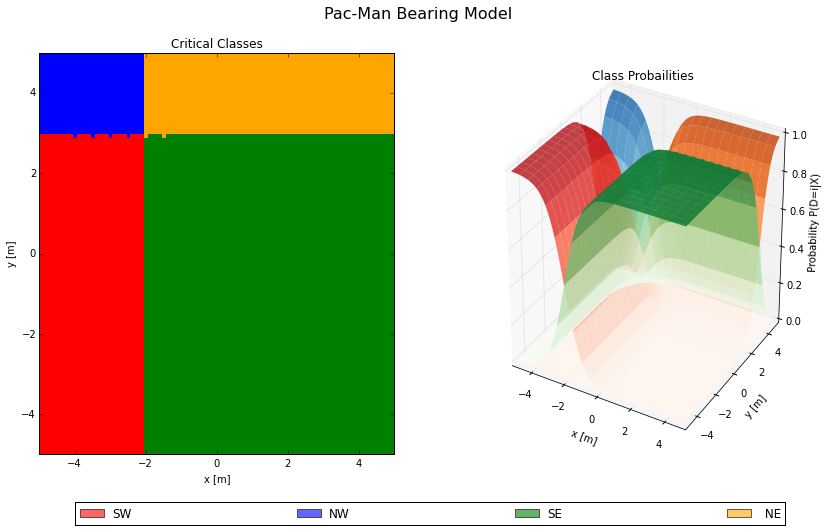

In [2]:
import numpy as np
from cops_and_robots.robo_tools.fusion.softmax import SoftMax
%matplotlib inline

labels = ['SW', 'NW', 'SE',' NE']
weights = np.array([[-1, -1],
                    [-1, 1],
                    [1, -1],
                    [1, 1],
                   ])

biases = np.array([1, -5, 5, -1,])
pacman = SoftMax(weights, biases, class_labels=labels)
pacman.plot(title='Shifted Pac-Man Bearing Model')

Remember the definition of our class boundaries:

\begin{align}
0 &= (\mathbf{w}_i - \mathbf{w}_j)^T\mathbf{x} + (b_i - b_j) \\
  &= (w_{i,x_1} - w_{j,x_1})x_1 + (w_{i,x_2} - w_{j,x_2})x_2 + \dots + (w_{i,x_n} - w_{j,x_n})x_n + (b_i - b_j)
\end{align}


From the equation of a plane, recall that the **normal vector** can be taken from the coefficients for the non-constant terms. Since the normal vector to a bounding hyperplane completely describes that hyperplane, we'll use the two terms interchangeably. In $\mathbb{R}^2$, each hyperplane is of the form $(w_{i,x} - w_{j,x})x + (w_{i,y} - w_{j,y})y + (b_i - b_j) = 0$.

We can define a normal vector for each class boundary:

$$
\begin{align}
\mathbf{n}_{SE,SW} &= (\mathbf{w}_{SW} - \mathbf{w}_{SE}) \\
&=\begin{bmatrix}-1 & -1\end{bmatrix}^T - \begin{bmatrix}1 & -1\end{bmatrix}^T = \begin{bmatrix}-2 & 0\end{bmatrix}^T \\
\mathbf{n}_{SW,NW} &= \begin{bmatrix}-1 & 1\end{bmatrix}^T - \begin{bmatrix}-1 & -1\end{bmatrix}^T = \begin{bmatrix}0 & 2\end{bmatrix}^T \\
\mathbf{n}_{NE,SE} &= \begin{bmatrix}1 & -1\end{bmatrix}^T - \begin{bmatrix}1 & 1\end{bmatrix}^T = \begin{bmatrix}0 & -2\end{bmatrix}^T \\
\mathbf{n}_{NW,NE} &= \begin{bmatrix}1 & 1\end{bmatrix}^T - \begin{bmatrix}-1 & 1\end{bmatrix}^T = \begin{bmatrix}2 & 0\end{bmatrix}^T \\
\end{align}
$$

But these aren't the only class boundaries -- diagonally positioned classes also have normals:

$$
\begin{align}
\mathbf{n}_{NW,SE} &= \begin{bmatrix}1 & -1\end{bmatrix}^T - \begin{bmatrix}-1 & 1\end{bmatrix}^T = \begin{bmatrix}2 & -2\end{bmatrix} \\
\mathbf{n}_{NE,SW} &= \begin{bmatrix}-1 & -1\end{bmatrix}^T - \begin{bmatrix}1 & 1\end{bmatrix}^T = \begin{bmatrix}-2 & -2\end{bmatrix} \\
\end{align}
$$

And we can define six more boundaries, but they're all mirror images of the ones we already have (i.e. $\mathbf{n}_{NW,SE} = - \mathbf{n}_{SE,NW}$). We'll ignore those for simplicity, but remember that we have 12 total normal vectors (and bias terms).

Let's figure out the **offset term** $d$ for each normal vector:

$$
\begin{align}
d_{SE,SW} &= b_{SW} - b_{SE} = 1 - 5 = -4 \\
d_{SW,NW} &=  -5 - 1 = -6\\
d_{NE,SE} &= 5 - (-1) = 6\\
d_{NW,NE} &= -1 - (-5) = 4\\
d_{NW,SE} &= 5 - (-5) = 10\\
d_{NE,SW} &= 1 - (-1) = 2\\
\end{align}
$$

We can represent each normal line in slope-intercept form. In [standard form](http://en.wikipedia.org/wiki/Linear_equation#General_.28or_standard.29_form), we have

$$
0 = \mathbf{n}\mathbf{x} + d
= n_xx + n_yy + d\\
$$

Which, in [slope-intercept form](http://en.wikipedia.org/wiki/Linear_equation#Slope.E2.80.93intercept_form), is 

$$
y = \frac{-n_x}{n_y}x + \frac{-d}{n_y} = mx + d'
$$

So, for each class:

$$
\begin{align}
y_{SE,SW} &= m_{SE,SW}x + d'_{SE,SW} = \frac{-2}{0}x + \frac{4}{0} \\
y_{SW,NW} &= \frac{0}{2}x + \frac{6}{2} = 3 \\
y_{NE,SE} &= \frac{0}{-2}x + \frac{-6}{-2} = 3 \\
y_{NW,NE} &= \frac{-2}{0}x + \frac{-4}{0}\\
y_{NW,SE} &= \frac{-2}{-2}x + \frac{-10}{-2} = x + 5 \\
y_{NE,SW} &= \frac{2}{-2}x + \frac{-2}{-2} = -x + 1 \\
\end{align}
$$

Note that, while $y_{SE,SW}$ and $y_{NW,NE}$ are undefined, we recognize them as vertical lines (as can be seen in standard form).

So we have a map of the normal vectors:

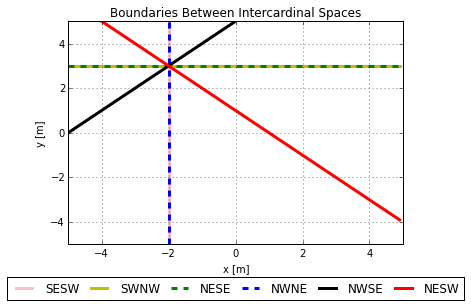

In [4]:
import numpy as np
from cops_and_robots.robo_tools.fusion.softmax import SoftMax
import matplotlib.pyplot as plt 
%matplotlib inline

x = np.arange(-5,5,0.1)
y_SESW = float('inf') * x + 2  # Vertical Line
y_SWNW = 0 * x + 3  # Horizontal Line
y_NESE = 0 * x + 3  # Horizontal Line
y_NWNE = float('inf') * x + 2  # Vertical Line
y_NWSE = x + 5
y_NESW = -x + 1

plt.axvline(x = -2, color='pink', ls='-', label="SESW", lw=3)
plt.plot(x, y_SWNW, 'y-', label="SWNW", lw=3)
plt.plot(x, y_NESE, 'g--', label="NESE", lw=3)
plt.axvline(x = -2, color='blue', ls='--' , label="NWNE", lw=3)
plt.plot(x, y_NWSE, 'k-', label="NWSE", lw=3)
plt.plot(x, y_NESW, 'r-', label="NESW", lw=3)

plt.grid()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.title('Boundaries Between Intercardinal Spaces')
plt.legend(loc='lower center', bbox_to_anchor=(-0.2, -0.275, 1.4, -0.175),
            mode='expand', ncol=6)

Using this visualization as a guide, we notice that the sum of all normal vectors is zero in each dimension (that is, they are symmetric about $x$ and $y$ in the shifted coordinate frame). Will this always be true? (Hint: we 'noticed' it because it's *important*.)

First, let's generalize to classes $i$,$j$, and $k$. Even non-critical classes share equiprobable zones (since the distribution for each class spans the entire state space), so each class will share some boundary with all other classes. This allows us to constrain the equations of the normal vectors:

$$
\begin{align}
\mathbf{n}_{i,j} &= \mathbf{w_j} - \mathbf{w_i} \\
\mathbf{n}_{j,k} &= \mathbf{w_k} - \mathbf{w_j} \\
\mathbf{n}_{k,i} &= \mathbf{w_i} - \mathbf{w_k} = -\mathbf{n}_{i,j} - \mathbf{n}_{j,k}\\
\end{align}
$$

From this, we can construct a transformation matrix $A$, where:

$$
\mathbf{n} = \mathbf{A}\mathbf{w}
$$

Where $a_{i,j} \in \{-1,0,1\}, \; \forall \: a_{i,j} \in A$. In defining our transformation matrix, we can translate between a weight specification and a normal vector specification in generating SoftMax models.

How do we find $A$? First, we know that $A$ is not <a href="http://en.wikipedia.org/wiki/Rank_%28linear_algebra%29">full rank</a>, because we can  reconstruct $\mathbf{n}_{k,i}$ from a linear combination of $\mathbf{n}_{i,j}$ and  $\mathbf{n}_{j,k}$. This means we can get an infinite number of mappings between weights and normal vectors (which makes sense, considering our earlier point that normals are generated from *relative* weights). We have a [consistent](http://en.wikipedia.org/wiki/System_of_linear_equations#Consistency) and [underdetermined](http://en.wikipedia.org/wiki/Underdetermined_system) linear system, which means we can impose arbitrary weights and normals, then accept any other values that lead to a solution.

Given a strict ordering of normals and weights, $A$ has a deterministic form. With classes $i$, $j$ and $k$, we have:

$$
\mathbf{n} = 
\begin{bmatrix}
\mathbf{n}_{i,j} \\
\mathbf{n}_{i,k} \\
\mathbf{n}_{j,k} \\
\end{bmatrix}
= \begin{bmatrix}
-1 & 1 & 0 \\
-1 & 0 & 1 \\
0 & -1 & 1 \\
\end{bmatrix}
\begin{bmatrix}
\mathbf{w}_i \\
\mathbf{w}_j \\
\mathbf{w}_k \\
\end{bmatrix}
= \mathbf{A}\mathbf{w}
$$

If we included a new class $l$, we would have:

$$
\mathbf{n} = 
\begin{bmatrix}
\mathbf{n}_{l,i} \\
\mathbf{n}_{l,j} \\
\mathbf{n}_{l,k} \\
\mathbf{n}_{i,j} \\
\mathbf{n}_{i,k} \\
\mathbf{n}_{j,k} \\
\end{bmatrix}
= \begin{bmatrix}
-1 & 1 & 0 & 0 \\
-1 & 0 & 1 & 0 \\
-1 & 0 & 0 & 1 \\
0 & -1 & 1 & 0 \\
0 & -1 & 0 & 1 \\
0 & 0 & -1 & 1 \\
\end{bmatrix}
\begin{bmatrix}
\mathbf{w}_l \\
\mathbf{w}_i \\
\mathbf{w}_j \\
\mathbf{w}_k \\
\end{bmatrix}
= \mathbf{A}\mathbf{w}
$$

You may have noticed the pattern developing in $\mathbf{A}$ already: $\mathbf{A}$ is an $\frac{M(M-1)}{2}$ by $M$ matrix where, in iterating through each class' not-yet-defined normals to all other classes, it takes the form of a column of $-1$ appended to an $\mathbf{I}$ matrix for each iteration. With a state-space of dimensionality $n$, this gives us $\frac{nM(M-1)}{2}$ equations and $nM$ total unknowns (contained in $M$ weight vectors of size $n$ by $1$).

But, since our system is overdetermined, we can specify only $M$ normals and still achieve $M$ weight vectors. To select our normals, we use [Rouché-Capelli's theorem](http://en.wikipedia.org/wiki/Rouch%C3%A9%E2%80%93Capelli_theorem) to assure ourselves that we have a unique solution. Using a subset of normals, called $\mathbf{n}_{min}$, we have at least one solution if:

$$ 
rank\left(\mathbf{A}_{min}\right) = rank\left(\left[\begin{array}{r|r} \mathbf{A}_{min} & \mathbf{n}_{min}\end{array}\right]\right)
$$

Where $\mathbf{A}_{min}$ is the transformation matrix between our minimal set of normals our weights. Our solution is unique if $rank\left(\mathbf{A_{min}}\right) = M$.

When doing a rank test, we can check for, say, 

$$
\mathbf{n}_{min} = 
\begin{bmatrix}
\mathbf{n}_{l,i} \\
\mathbf{n}_{l,j} \\
\mathbf{n}_{l,k} \\
\mathbf{n}_{i,j} \\
\end{bmatrix}
= \begin{bmatrix}
-1 & 1 & 0 & 0 \\
-1 & 0 & 1 & 0 \\
-1 & 0 & 0 & 1 \\
0 & -1 & 1 & 0 \\
\end{bmatrix}
\begin{bmatrix}
\mathbf{w}_l \\
\mathbf{w}_i \\
\mathbf{w}_j \\
\mathbf{w}_k \\
\end{bmatrix}
= \mathbf{A}_{min}\mathbf{w}
$$

Similarly, we can find the bias terms for each class by knowing the offsets of the normal vectors, that is:

$$
\begin{align}
d_{i,j} &= b_j - b_i \\
d_{j,k} &= b_k - b_j \\
d_{k,i} &= b_i - b_k = -d_{i,j} - d_{j,k}\\
\end{align}
$$

Which gives us a similar form to figure out all our bias terms. Let $\mathbf{b} = \begin{bmatrix}b_i & b_j & b_k\end{bmatrix}^T$ and $\mathbf{d} = \begin{bmatrix}d_{i,j} & d_{j,k} & d_{k,i}\end{bmatrix}^T$ (both generalizable for any number of classes). Following the previous logic, we have:

$$
\mathbf{d} = \mathbf{A}\mathbf{b}
$$

and

$$
\mathbf{d}_{min} = \mathbf{A}_{min}\mathbf{b}
$$

Where $A$ is the same transformation matrix as before.

### Example: T-shape Pac-Man and weights from normals

Let's say we want to partition the space in a T-shape, with the North-East, North-West and South spaces. We can define our normal vectors by inspection (i.e. $\mathbf{n}_{NE,NW}^T  = \begin{bmatrix}1 & 0 \end{bmatrix}$ because we need a positive $x$ component to move from NW to NE).

We should simply be able to plug these normals into our previous transformation equation:

$$
\mathbf{n} 
= \begin{bmatrix}
\mathbf{n}_{NW,NE}^T \\ 
\mathbf{n}_{NW,S}^T \\ 
\mathbf{n}_{NE,S}^T \\
\mathbf{n}_{S,NE}^T \\
\mathbf{n}_{S,NW}^T \\ 
\mathbf{n}_{NE,NW}^T \\ 
\end{bmatrix} 
= \begin{bmatrix}
1 & 0 \\
0 & -1 \\
0 & -1 \\
0 & 1 \\
0 & 1 \\
-1 & 0 \\
\end{bmatrix} 
= \begin{bmatrix}
-1 & 1 & 0 \\
-1 & 0 & 1 \\
0 & -1 & 1 \\
0 & 1 & -1 \\
1 & 0 & -1 \\
1 & -1 & 0 \\
\end{bmatrix}
\begin{bmatrix}
\mathbf{w}_{NW}^T \\
\mathbf{w}_{NE}^T \\
\mathbf{w}_{S}^T
\end{bmatrix} 
= \mathbf{A}\mathbf{w}
$$

But we don't need to specify all the normal vectors in order to get our weights, so let's try a minimal representation:

$$
\mathbf{n}_{min}
= \begin{bmatrix}
\mathbf{n}_{NW,NE}^T \\ 
\mathbf{n}_{NW,S}^T \\ 
\mathbf{n}_{NE,S}^T \\
\end{bmatrix} 
= \begin{bmatrix}
-1 & 0 \\
0 & 1 \\
0 & 1 \\
\end{bmatrix} 
= \begin{bmatrix}
-1 & 1 & 0 \\
-1 & 0 & 1 \\
0 & -1 & 1
\end{bmatrix}
\begin{bmatrix}
\mathbf{w}_{NW}^T \\
\mathbf{w}_{NE}^T \\
\mathbf{w}_{S}^T
\end{bmatrix} 
= \mathbf{A}_{min}\mathbf{w}
$$

Have you spotted the problem yet? We set up the following system of equations:

$$
\begin{bmatrix}
-1 & 0 \\
0 & 1 \\
0 & 1 \\
\end{bmatrix} 
= \begin{bmatrix}
-1 & 1 & 0 \\
-1 & 0 & 1 \\
0 & -1 & 1
\end{bmatrix}
\begin{bmatrix}
w_{NW,x} & w_{NW,y} \\
w_{NE,x} & w_{NE,y} \\
w_{S,x} & w_{S,y} \\
\end{bmatrix} 
$$

But this system is **inconsistent**, as it gives equations such as:

$$
\begin{align}
w_{NE,x} - w_{NW,x} = -1 \\
w_{S,x} - w_{NW,x} = 0 \\
w_{S,x} - w_{NE,x} = 0
\end{align}
$$

for which there is no solution – that is, we cannot specify weights to appropriately partition the state space. This is further validated by our rank test, but, to perform the rank test, we need to vectorize the values we're solving for:

$$
\begin{bmatrix}
-1 \\ 0 \\
0 \\ 1 \\
0 \\ 1 \\
\end{bmatrix} 
= \begin{bmatrix}
-1 & 1 & 0 \\
-1 & 1 & 0 \\
-1 & 0 & 1 \\
-1 & 0 & 1 \\
0 & -1 & 1 \\
0 & -1 & 1
\end{bmatrix}
\begin{bmatrix}
w_{NW,x} \\ w_{NW,y} \\
w_{NE,x} \\ w_{NE,y} \\
w_{S,x} \\ w_{S,y} \\
\end{bmatrix} 
$$

$$ 
rank\left(\begin{array}{rrr|r} 
-1 & 1 & 0 & -1 \\
-1 & 0 & 1 & 0 \\
0 & -1 & 1 & 0 \\
-1 & 1 & 0 & 0 \\
-1 & 0 & 1 & 1 \\
0 & -1 & 1 & 1
\end{array}\right)
$$

How do we fix it? We can split the southern class up into two subclasses: SE and SW. This gives us the normal vectors we'd solved for in the previous case. Let's plug these in and find some weights:

$$
\mathbf{N} = \begin{bmatrix}
\mathbf{n}_{NW,NE}^T \\
\mathbf{n}_{NW,SE}^T \\
\mathbf{n}_{NW,SW}^T \\
\mathbf{n}_{NE,SE}^T \\
\mathbf{n}_{NE,SW}^T \\
\mathbf{n}_{SE,SW}^T \\ 
\end{bmatrix} 
= \begin{bmatrix}
2 & 0 \\
2 & -2 \\
0 & -2 \\
0 & -2 \\
-2 & -2 \\
-2 & 0 \\
\end{bmatrix} 
= \begin{bmatrix}
-1 & 1 & 0 & 0 \\
-1 & 0 & 1 & 0 \\
-1 & 0 & 0 & 1 \\
0 & -1 & 1 & 0 \\
0 & -1 & 0 & 1 \\
0 & 0 & -1 & 1
\end{bmatrix}
\begin{bmatrix}
\mathbf{w}_{NW}^T \\
\mathbf{w}_{NE}^T \\
\mathbf{w}_{SE}^T \\
\mathbf{w}_{SW}^T \\
\end{bmatrix} 
= \mathbf{A}\mathbf{W}
$$

Using our favourite [matrix decomposition technique](http://en.wikipedia.org/wiki/Matrix_decomposition) we can solve for our weights. Note that, for a strict ordering, the form of matrix $A$ should be generalizable -- that is, we do not need to re-solve $A$ for each number of weights or normals, nor the dimensionality of the state vector. We'll get to how to generalize $A$ after we've finished solving this example.

We can use the same technique to solve for our biases from our offsets:

$$
\mathbf{d}
= \begin{bmatrix}
d_{NW,NE} \\
d_{NW,SE} \\
d_{NW,SW} \\
d_{NE,SE} \\
d_{NE,SW} \\
d_{SE,SW} \\ 
\end{bmatrix}
= \begin{bmatrix}
4 \\
10 \\
6 \\
6 \\
2 \\
-4 \\ 
\end{bmatrix}
= \begin{bmatrix}
-1 & 1 & 0 & 0 \\
-1 & 0 & 1 & 0 \\
-1 & 0 & 0 & 1 \\
0 & -1 & 1 & 0 \\
0 & -1 & 0 & 1 \\
0 & 0 & -1 & 1
\end{bmatrix}
\begin{bmatrix}
b_{NW} \\
b_{NE} \\
b_{SE} \\
b_{SW}
\end{bmatrix} 
= \mathbf{A}\mathbf{b}
$$

Let's see if we can solve for the weights and biases of our Pac-Man example by just specifying the normals and offsets:

Weights:
[[-1.  1.]
 [ 1.  1.]
 [ 1. -1.]
 [-1. -1.]]
Biases:[-5. -1.  5.  1.]


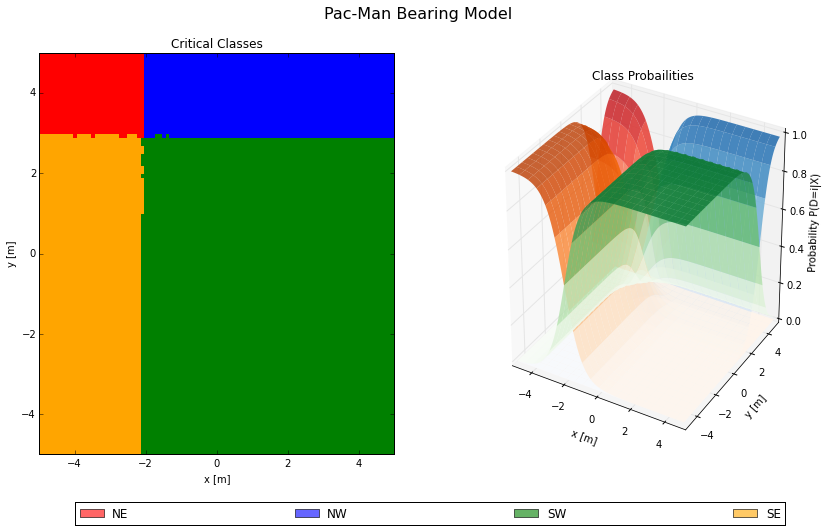

In [20]:
np.set_printoptions(precision=2, suppress=True)
A = np.array([[-1, 1, 0, 0],
              [-1, 0, 1, 0],
              [-1, 0, 0, 1],
              [0, -1, 1, 0],
             ])

# Solve for weights
n = np.array([[2, 0],
              [2, -2],
              [0, -2],
              [0, -2],])

w = np.dot(np.linalg.pinv(A),n)  # Using the Moore-Penrose pseudo-inverse
print('Weights:\n{}'.format(w))

# Solve for biases
d = np.array((4, 10, 6, 6))
biases = np.dot(np.linalg.pinv(A), d)
print('Biases:{}'.format(biases))

labels = ['NE','NW','SW','SE']
pacman = SoftMax(weights=w, biases=biases, class_labels=labels)
pacman.plot(title='Pac-Man Bearing Model')

That looks about right (save for the color scheme). Except, what we wanted was one class to represent the South, and one class to represent North-East and one to represnt North-West. We can't do that with our current SoftMax model, because the normals wouldn't sum to zero, but we'll investigate a technique called Multimodal SoftMax in [Chapter 4](04_mms.ipynb) to resolve this problem.

**NOT TRUE** Note the weights generated by our decomposition are unit vectors, as opposed to the vectors of magnitude $\sqrt{2}$ that we'd originally used. The slopes for the probability distributions from weights are less steep than our original case, even if the class boundaries are identical. Thankfully, our math works out such that we can control the slope of the SoftMax distributions by changing the magnitude of the normals, like so:

In [7]:
n = np.array([[0,5,0],
              [0,0,-5],
              [0,-5,0],
              [0,0,5]])
A = np.roll(np.eye(4,4),1,axis=1) - np.eye(4,4)
w = np.dot(np.linalg.pinv(A),n)  # Using the Moore-Penrose pseudo-inverse
print(w)

labels = ['SW','NW','SE','NE']
pacman = SoftMax(weights=w, class_labels=labels)
pacman.plot(title='Pac-Man Bearing Model')

[[ 0.  -2.5  2.5]
 [ 0.   2.5  2.5]
 [ 0.   2.5 -2.5]
 [ 0.  -2.5 -2.5]]


ValueError: shapes (10201,2) and (3,) not aligned: 2 (dim 1) != 3 (dim 0)

In [8]:
from IPython.core.display import HTML

# Borrowed style from Probabilistic Programming and Bayesian Methods for Hackers
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()